In [82]:
import artm
import pickle
import numpy as np

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from utils import run_hyperparams_search, fit_best_model, prepare_vis_data


SEED = 12
N_TOKENS = 10000

In [67]:
# загрузка тех же, уже предобработанных для LDA данных
data = pickle.load(open('./data/lenta_small_part_filtered.pkl', 'rb'))
data = [' '.join(token_list) for token_list in data]

cv = CountVectorizer(max_features=N_TOKENS, max_df=0.9, min_df=0.05, ngram_range=(1, 2))
n_wd = np.array(cv.fit_transform(data).todense()).T
token_list = [i for i in cv.vocabulary_.keys()]

bv = artm.BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd, vocabulary=token_list)

/opt/conda/lib/python3.10/site-packages/artm/batches_utils.py:227: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


In [83]:
# задача для оптимизации в ходе поиска гиперпараметров модели

def minimalisation_task(space):
    model = artm.ARTM(num_topics=space['num_topics'], dictionary=bv.dictionary, cache_theta=True)

    model.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=bv.dictionary))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
    model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=N_TOKENS))

    model.regularizers.add( # Сглаживание распределений терминов в темах. Используется для выделения фоновых тем, собирающих общую лексику языка или общую лексику данной коллекции.
        artm.SmoothSparsePhiRegularizer(
            name='SparsePhi',
            tau=space['phi_tau']
    ))
    model.regularizers.add( # Сглаживание распределений тем в документах. Используется для выделения фоновых слов в каждом документах.
        artm.SmoothSparseThetaRegularizer(
            name='SparseTheta',
            tau=space['theta_tau']
        ))
    model.regularizers.add(  # Декоррелирование распределений терминов в темах. Используется для повышения различности лексических ядер предметных тем.
        artm.DecorrelatorPhiRegularizer(
            name='DecorrelatorPhi',
            tau=space['decorrelation_tau']
        ))

    model.fit_offline(bv, num_collection_passes=30)

    perplexity_score = model.score_tracker["perplexity_score"].last_value
    print("Perplexity:", perplexity_score)

    return {'loss': perplexity_score, 'status': STATUS_OK }

In [84]:
# найдем параметры для минимальной перплексии
best_hyperparams = run_hyperparams_search(minimalisation_task)
best_hyperparams

Perplexity:                                           
139.27967834472656                                    
Perplexity:                                                                     
143.49888610839844                                                              
Perplexity:                                                                     
132.99105834960938                                                              
Perplexity:                                                                     
139.01669311523438                                                              
Perplexity:                                                                     
142.72900390625                                                                 
Perplexity:                                                                     
134.6748809814453                                                               
Perplexity:                                                                     

{'DecorrelatorPhi': 88920.08438943842,
 'SparsePhi': -0.09370183921627478,
 'SparseTheta': -0.004285642440952767,
 'num_topics': 13}

In [87]:
%%time
model = fit_best_model(best_hyperparams, bv, seed=SEED)

CPU times: user 1min 40s, sys: 2.48 s, total: 1min 43s
Wall time: 26.9 s


### Графики

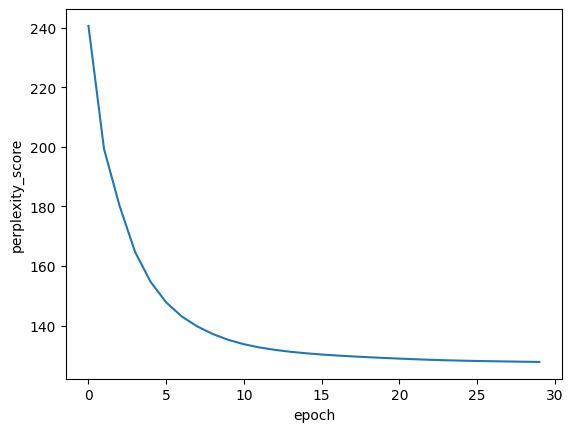

In [88]:
plt.plot(model.score_tracker["perplexity_score"].value)
plt.ylabel('perplexity_score')
plt.xlabel('epoch');

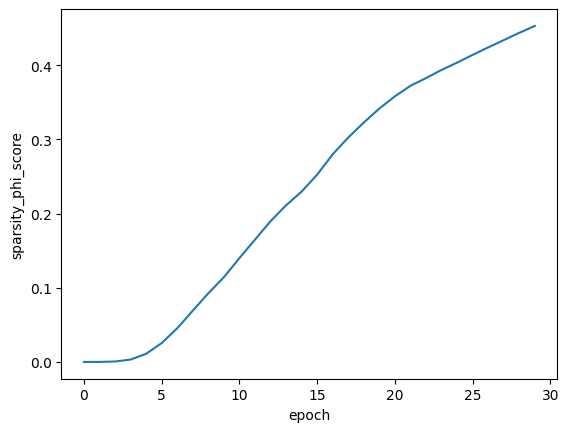

In [89]:
plt.plot(model.score_tracker["sparsity_phi_score"].value)
plt.ylabel('sparsity_phi_score')
plt.xlabel('epoch');

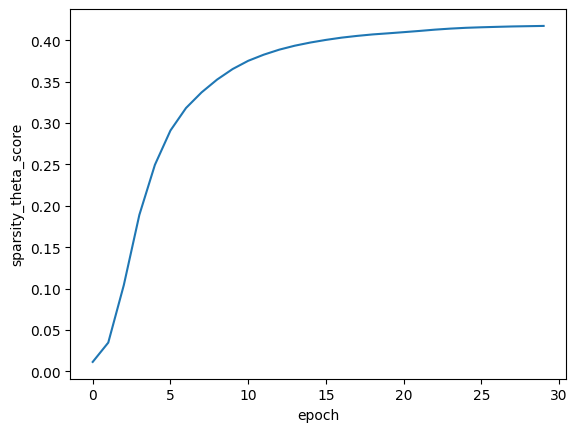

In [90]:
plt.plot(model.score_tracker["sparsity_theta_score"].value)
plt.ylabel('sparsity_theta_score')
plt.xlabel('epoch');

### Визуализация работы

In [93]:
pyLDAvis.enable_notebook()
model_data = prepare_vis_data(model, n_wd)
model_vis = pyLDAvis.prepare(**model_data)
pyLDAvis.display(model_vis)

/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Субьективно, gensim.LDA лучше разбивал на темы, плюс ко всему они лежали дальше друг от друга. Возможно это связано со способом токенизации